# Extracting from free text with MedCAT

This tutorial serves as an introduction on how to use *ehrapy* together with [MedCAT](https://github.com/CogStack/MedCAT). *MedCat* is a tool to extract medical entities from free text and link it to biomedical ontologies. Biomedical entities could be anything biomedical; not only diagnoses or diseases but also symptoms, drugs or even peptides. 
It also tries to keep the context of an extracted entitiy (for example, whether a specific disease has been diagnosed or not). This is especially important for electronic health records data, as most of the time doctors notes are simply copied and pasted into the data and not preprocessed in any form. Consider the following example:

- The patient suffers from diabetes.

 vs.
 
- The patient does not suffer from diabetes.


In detail, ehrapy uses a pretrained and packages model from MedCat (https://medcat.readthedocs.io/en/latest/main.html#models). This model is limited in performance but good enough for this demonstration. A larger (trained) model is planned to be released somewhen in the (near) future by the MedCAT maintainers.

In [1]:
import ehrapy as ep
import pandas as pd

Installed version 0.3.0 of ehrapy is newer than the latest release 0.2.0! You are running a 
nightly version and features may break!

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/medcat/cat.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
ep.settings.n_jobs = 8

Download the example data

In [3]:
!wget -nc https://raw.githubusercontent.com/CogStack/MedCAT/master/tutorial/data/pt_notes.csv -P ./medcat_data/
!wget -nc https://medcat.rosalind.kcl.ac.uk/media/medmen_wstatus_2021_oct.zip -P ./medcat_data/

File ‘./medcat_data/pt_notes.csv’ already there; not retrieving.

File ‘./medcat_data/medmen_wstatus_2021_oct.zip’ already there; not retrieving.



# Custom MedCAT object of ehrapy

To allow for seemless interoperability of ehrapy and MedCAT, we require a "superobject" that references the AnnData object while providing the MedCAT functionality. This object further stores MedCAT related features such as a *vocabulary*, a *concept database* and (later on in this tutorial) also the *annotated results*.

First, we read the example data into an AnnData object, encode the data and calculate neighbors for subsequent processing.
As a next step, we create the MedCAT object with a modelpack and set default TUI filters.
A full list of TUI’s can be found at: https://lhncbc.nlm.nih.gov/ii/tools/MetaMap/Docs/SemanticTypes_2018AB.txt

In [4]:
adata = ep.io.read_csv("medcat_data/pt_notes.csv", columns_obs_only=["text"])
adata_encoded = ep.pp.encode(adata, autodetect=True)
ep.pp.neighbors(adata_encoded)

# create the main ehrapy medcat object used for medical entitiy analysis using ehrapy and medcat
ep_medcat = ep.tl.MedCAT(
    adata_encoded, model_pack_path="./medcat_data/medmen_wstatus_2021_oct"
)
# only use diseases and behavioural disorders diagnoses in this example by filtering by TUI
ep_medcat.set_filter_by_tui(tuis=["T047", "T048"])

Output()

/home/zeth/PycharmProjects/ehrapy/ehrapy/preprocessing/encoding/_encode.py:227: 
FutureWarning: X.dtype being converted to np.float32 from object. In the next version of 
anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. 
Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  encoded_ann_data = AnnData(

Found an existing unziped model pack at: ./medcat_data/medmen_wstatus_2021_oct, the provided zip will not be touched.
{
  "Model ID": null,
  "Last Modifed On": null,
  "History (from least to most recent)": [],
  "Description": "No description",
  "Source Ontology": null,
  "Location": null,
  "MetaCAT models": {},
  "Basic CDB Stats": {},
  "Performance": {
    "ner": {},
    "meta": {}
  },
  "Important Parameters (Partial view, all available in cat.config)": {
    "config.ner['min_name_len']": {
      "value": 3,
      "description": "Minimum detection length (found terms/mentions shorter than this will not be detected)."
    },
    "config.ner['upper_case_limit_len']": {
      "value": 3,
      "description": "All detected terms shorter than this value have to be uppercase, otherwise they will be ignored."
    },
    "config.linking['similarity_threshold']": {
      "value": 0.2,
      "description": "If the confidence of the model is lower than this a detection will be ignore."
 

Using this model pack we can already extract entities from an example note.

In [5]:
text = "He was diagnosed with kidney failure"
doc = ep_medcat.cat(text)
doc.ents

(kidney failure,)

In [6]:
# Example output of an extracted medcat entity; note that ehrapy will deal with this automatically and the here displayed manual extraction is not required.
# CUI: Concept Unique Identifier, which is just an unique identifier for each concept extracted
ep_medcat.cat.get_entities("He was diagnosed with kidney failure", only_cui=False)

{'entities': {2: {'pretty_name': 'Kidney Failure',
   'cui': 'C0035078',
   'type_ids': ['T047'],
   'types': ['Disease or Syndrome'],
   'source_value': 'kidney failure',
   'detected_name': 'kidney~failure',
   'acc': 1.0,
   'context_similarity': 1.0,
   'start': 22,
   'end': 36,
   'icd10': [],
   'ontologies': [],
   'snomed': [],
   'id': 2,
   'meta_anns': {'Status': {'value': 'Affirmed',
     'confidence': 0.9999961853027344,
     'name': 'Status'}}}},
 'tokens': []}

# Extracting and visualizing all disease entities

To extract all disease entities from our example dataset we require a complete annotation of the dataset. This step is computationally expensive and may take some time.

In [7]:
ep.tl.mc.annotate_text(ep_medcat, text_column="text", n_proc=8)

Annotated until now: 0 docs; Current BS: 157 docs; Elapsed time: 0.00 minutes
Annotated until now: 26 docs; Current BS: 165 docs; Elapsed time: 0.11 minutes
Annotated until now: 55 docs; Current BS: 151 docs; Elapsed time: 0.22 minutes
Annotated until now: 72 docs; Current BS: 160 docs; Elapsed time: 0.33 minutes
Annotated until now: 90 docs; Current BS: 152 docs; Elapsed time: 0.43 minutes
Annotated until now: 114 docs; Current BS: 130 docs; Elapsed time: 0.54 minutes
Annotated until now: 128 docs; Current BS: 157 docs; Elapsed time: 0.64 minutes
Annotated until now: 148 docs; Current BS: 16 docs; Elapsed time: 0.75 minutes


The annotated results as extracted by MedCAT are transformed and stored into a Pandas DataFrame

In [8]:
ep_medcat.annotated_results

,row_nr,pretty_name,cui,type_ids,types,meta_anns
0,0,Diabetes,C0011847,[T047],[Disease or Syndrome],Affirmed
1,0,Sepsis,C0243026,[T047],[Disease or Syndrome],Other
2,0,"Respiratory Distress Syndrome, Adult",C0035222,[T047],[Disease or Syndrome],Affirmed
3,0,Pulmonary Embolism,C0034065,[T047],[Disease or Syndrome],Other
4,0,Respiratory Failure,C1145670,[T047],[Disease or Syndrome],Affirmed
...,...,...,...,...,...,...
1638,934,Memory impairment,C0233794,[T048],[Mental or Behavioral Dysfunction],Affirmed
1639,934,Erythema,C0041834,[T047],[Disease or Syndrome],Other
1640,934,disorder lesions skin,C0037284,[T047],[Disease or Syndrome],Other
1641,934,Zika Virus Infection,C0276289,[T047],[Disease or Syndrome],Other


We can also get a proper overview for the top 10 most entities found in the data (affirmed diagnoses only).

In [9]:
ep.tl.mc.get_annotation_overview(ep_medcat)

 pretty_name          type_ids   types                n_patient_visit   n_patient_visit_p…  
 ─────────────────────────────────────────────────────────────────────────────────────────── 
  Hypertensive         T047       Disease or           80                50.0                
  disease                         Syndrome                                                   
  Obesity              T047       Disease or           60                37.5                
                                  Syndrome                                                   
  Asthma               T047       Disease or           32                20.0                
                                  Syndrome                                                   
  Cerebrovascular      T047       Disease or           27                16.875              
  accident                        Syndrome                                                   
  Diabetes Mellitus    T047       Disease or           26                16.25               
                                  Syndrome                                                   
  Hypercholesterole…   T047       Disease or           25                15.625              
                                  Syndrome                                                   
  Coronary             T047       Disease or           24                15.0                
  Arteriosclerosis                Syndrome                                                   
  Hypothyroidism       T047       Disease or           23                14.374999999999998  
                                  Syndrome                                                   
  Mental Depression    T048       Mental or            20                12.5                
                                  Behavioral                                                 
                                  Dysfunction                                                
  Diabetes             T047       Disease or           20                12.5                
                                  Syndrome                                                  

Alternatively, we can also get an overview of the top 10 negated diagnoses only.

In [10]:
ep.tl.mc.get_annotation_overview(ep_medcat, status="Other")

 pretty_name          type_ids   types                n_patient_visit   n_patient_visit_p…  
 ─────────────────────────────────────────────────────────────────────────────────────────── 
  Cerebrovascular      T047       Disease or           17                15.04424778761062   
  accident                        Syndrome                                                   
  Diabetes             T047       Disease or           14                12.389380530973451  
                                  Syndrome                                                   
  Coronary             T047       Disease or           12                10.619469026548673  
  Arteriosclerosis                Syndrome                                                   
  Disease              T047       Disease or           11                9.734513274336283   
                                  Syndrome                                                   
  Pulmonary Embolism   T047       Disease or           11                9.734513274336283   
                                  Syndrome                                                   
  Erythema             T047       Disease or           10                8.849557522123893   
                                  Syndrome                                                   
  Incontinence         T047       Disease or           8                 7.079646017699115   
                                  Syndrome                                                   
  Rheumatism           T047       Disease or           8                 7.079646017699115   
                                  Syndrome                                                   
  Dementia             T048       Mental or            8                 7.079646017699115   
                                  Behavioral                                                 
                                  Dysfunction                                                
  Atherosclerosis      T047       Disease or           7                 6.1946902654867255  
                                  Syndrome                                                  

Since our MedCAT is aware of both, the annotation results and the AnnData object, we can just pass it to any plotting functions of ehrapy, just we like we are used to with AnnData objects.
First, we calculate a UMAP embedding using the AnnData object and then we color by all patients that had some form of Pneumonia.

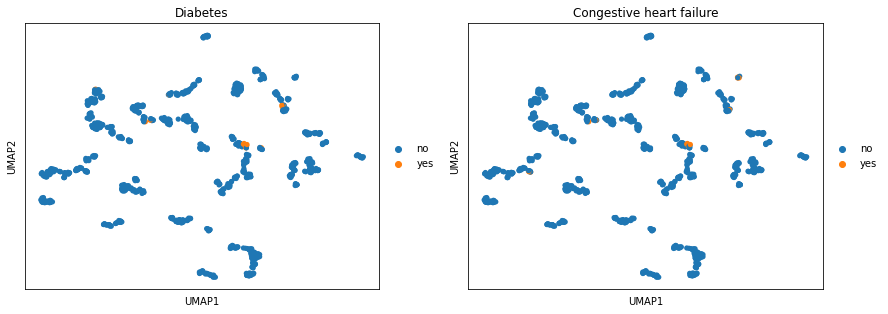

In [11]:
ep.tl.umap(ep_medcat.anndata)
ep.pl.umap(ep_medcat, color=["Diabetes", "Congestive heart failure"])

It is still possible to color by the original columns in the AnnData object with the MedCAT object.

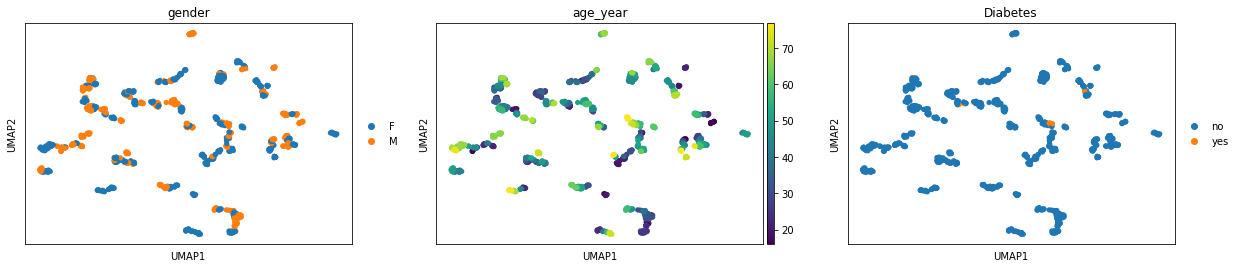

In [12]:
ep.pl.umap(ep_medcat, color=["gender", "age_year", "Diabetes"])

Passing an AnnData object instead of an ehrapy MedCAT object will also work, but not with extracted entities.

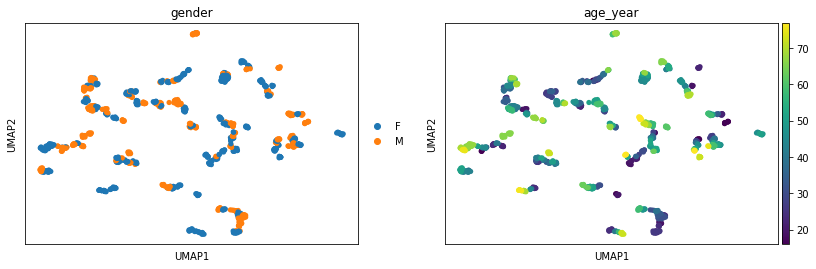

In [13]:
ep.pl.umap(ep_medcat.anndata, color=["gender", "age_year"])

Typos are automatically fixed by ehrapy whenever possible.

Did not find Diubetes in medcat's extracted entities. Will use best match Diabetes!

Did not find Heart Failure in medcat's extracted entities. Will use best match Congestive 
heart failure!

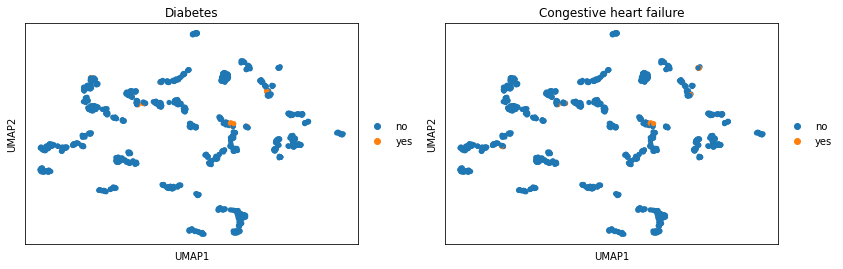

In [14]:
ep.pl.umap(ep_medcat, color=["Diubetes", "Heart Failure"])

All other features of ehrapy are of course also available.

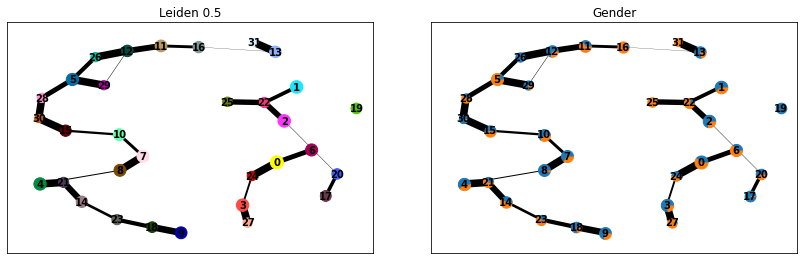

In [15]:
ep.tl.leiden(ep_medcat.anndata, resolution=0.5, key_added="leiden_0_5")
ep.tl.paga(ep_medcat.anndata, groups="leiden_0_5")

# paga currently does not support medcat extracted entities directly (as of ehrapy 0.2.0)
ep.pl.paga(
    ep_medcat.anndata,
    color=["leiden_0_5", "gender"],
    cmap=ep.pl.Colormaps.grey_red.value,
    title=["Leiden 0.5", "Gender"],
)

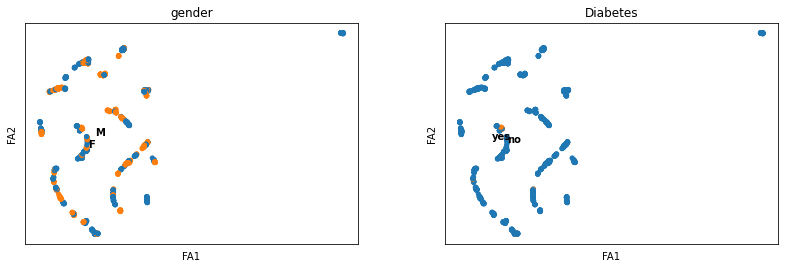

In [16]:
ep.tl.draw_graph(ep_medcat.anndata, init_pos="paga")
ep.pl.draw_graph(ep_medcat, color=["gender", "Diabetes"], legend_loc="on data")

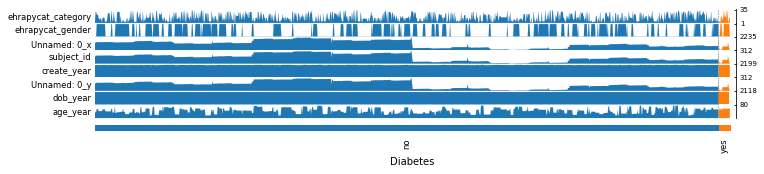

In [17]:
ep.pl.tracksplot(ep_medcat, list(ep_medcat.anndata.var_names), groupby="Diabetes")